In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
import scipy



import tensorflow as tf

import matplotlib as mpl
import os
import plotly.graph_objects as go
from prettytable import PrettyTable

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

In [6]:
from process import process as prc
from process import fix_nan
from process import add_holiday_flag, SMAPE, WAPE

In [7]:
def add_holiday_flag(df, start_day, end_day, flag_name):
    nov_mar_series = pd.Series(pd.date_range(start_day, end_day))
    nov_mar_no_year = nov_mar_series.map(lambda x: x.strftime("%m-%d"))
    no_year_mask = df['no_year'].isin(nov_mar_no_year)
    df.loc[no_year_mask, flag_name] = 1
    df[flag_name] = df[flag_name].fillna(0)
    df[flag_name] = df[flag_name].astype(int)
    return df


In [8]:
def to_sin(date):
    return np.sin((date-pd.to_datetime('{}-01-01'.format(date.year))).days/366)
def to_cos(date):
    return np.cos((date-pd.to_datetime('{}-01-01'.format(date.year))).days/366)
def upd_data(data):
    data['sin']=data['period_start_dt'].apply(to_sin)
    data['cos']=data['period_start_dt'].apply(to_cos)    

### Теоретический план пайплайна

1) Загрузить данные  
2) Обработать  
3) Нарезать на батчи и тесты  
4) Обучить модель  
5) Нарисовать графики  


In [124]:
class Pipeline:
    modify_list = []
    batch_len = 52
    train_lim = 105
    metrics = {"mse":lambda x,y:((x-y)**2).sum(),
              "wape":WAPE,
              "smape":SMAPE}
    
    def set_path(self,path):
        """
        path - локальный путь до файла csv
        """
        data_path = path
        self.raw_data = pd.read_csv(path)
        self.non_na_data = self.raw_data.fillna(0.0)
        
    def feature_amount(self):
        """
        ---
        возвращает число фич
        вызывается после обработки данных
        """
        return self.train[0][0][0][0].shape[-1]
    def _process(self,data):
        data['period_start_dt'] = pd.to_datetime(data['period_start_dt'])
        data["no_year"] = self.data['period_start_dt'].map(lambda x: x.strftime("%m-%d"))
        
        data = add_holiday_flag(data, "2013-02-12", "2013-02-16", "flag_14FEB")
        data = add_holiday_flag(data, "2013-02-20", "2013-02-24", "flag_23FEB")
        data = add_holiday_flag(data, "2013-03-06", "2013-03-10", "flag_8MAR")
        data = add_holiday_flag(data, "2013-05-07", "2013-05-11", "flag_9MAY")
        data = add_holiday_flag(data, "2013-08-07", "2013-09-30", "flag_1SEP")
        data = add_holiday_flag(data, "2013-12-30", "2013-12-31", "flag_NEW_YEAR")
        data = add_holiday_flag(data, "2013-01-01", "2013-01-03", "flag_NEW_YEAR")

        data = data.drop(columns=['no_year'])
        return prc(data).fillna(0.0)
    def process(self):
        self.data = self.non_na_data
        self.data = self._process(self.data)
        
    def compile_train_ds(self):
        self.train = []
        self.scalers = {}
        
        def split(ds,scaler):

            y = ds.demand.values.reshape(-1, 1)
            
            
            #вроде работает, но так странно, что я не могу...
            self.batch_processing(ds)
            x = scaler.fit_transform(ds.drop('demand',axis=1))
            #--------
            #альтернатива
            #x = ds.drop('demand',axis=1).values
            
            ts = TimeseriesGenerator(x[:self.train_lim], y[:self.train_lim], self.batch_len) 
            #[0] is x, [1] is y
            return list(ts)
        
        def make_ds(dataset):
            grouped_data = dataset.groupby(['product_rk','store_location_rk'])
            #this array is [[key,values by key],...] list
            batches = np.array(grouped_data)[:,1] #only values
            for i in range(batches.shape[0]):
                #checking amount of weeks
                if batches[i].shape[0] <= 150:
                    continue
                batch = batches[i]
                key = tuple(batch[['product_rk','store_location_rk']].head(1).values[0])
                self.scalers[key] = MinMaxScaler(feature_range=(0, 1))

                for update in self.modify_list:
                    update(batch)
                    
                batch.drop(['product_rk','store_location_rk','period_start_dt'], axis=1, inplace=True)

                batch.reset_index(drop=True, inplace=True)
                self.train.append(split(batch,self.scalers[key]))

        
        make_ds(self.data)
    def split(self,rate = 0.2):
        self.test = self.train[:int(len(self.train)*rate)]
        self.train = self.train[int(len(self.train)*rate):]

    def modify_data(self, functon, mutating = False):
        if mutating:
            functon(self.data)
        else:
            self.data = functon(self.data)
            
    def batch_processing(self, batch, lim = self.train_lim):
        # для предсказания нужны:
        # l, b за прошлый период
        # s за m периодов назад
        # y_hat за текущий период
        m=self.batch_len
        def compute_components(X, known_len):
            alpha = beta = gamma = 0.0005
            n = X.shape[0]
            l = np.zeros(n+1)
            b = np.zeros(n+1)
            s = np.zeros(n+1)
            y_hat = np.zeros(n+1)
            l[0] = sum(X[0:known_len:m]) / (known_len//m + 1) + 0.001
            if n < m:
                l[0] = 1
            for i in range(min(m, n)):
                s[i] = X[i]/l[0]
            if 2*m < n:
                #print(X[m:2*m].sum(), X[0:m].sum())
                b[0] = np.exp(1/m*(np.log(X[m:2*m].sum() + 0.001) - np.log(X[0:m].sum() + 0.001)))
            else:
                b[0] = 1
            for t in range(1, n):
                l[t] = alpha*y_hat[t]
                if (t >= m):
                    l[t] /= (s[t-m] + 0.01)
                    s[t] = gamma*X[t]/(l[t-1]*b[t-1]) + (1 - gamma)*s[t-m]
                l[t] += (1 - alpha)*l[t-1]*b[t-1]
                b[t] = beta*l[t]/(l[t-1] + 0.001) + (1-beta)*b[t-1]
                y_hat[t+1] = l[t]*b[t]
                if (t - m + 1 >= 0):
                    y_hat[t+1] *= s[t-m+1]

            return l, b, s, y_hat
        batch['l'] = 0
        batch['s'] = 1
        batch['b'] = 0
        batch['y'] = 0
        n = batch.demand.shape[0]
        l, b, s, y_hat = compute_components(batch.demand.to_numpy(), lim)
        #print(X_curr.columns)
        batch['y'] = y_hat[:-1]
        batch['l'] = l[1:]
        batch['b'] = b[1:]
        s = [1]*m + list(s)
        batch['s'] = s[:-m-1]
        
        
    def process_custom_batch(self,batch_data, scaler_id):
            batch_data
            for update in self.modify_list:
                    update(batch_data)
            self.batch_processing(batch_data,-1)
            self.scalers[batch_data].trans(self.batch_data)

            
            
    #require function which add column to origin data
    def modify(self,function):
        self.modify_list.append(function)
        
    def set_model(self, model):
        self.model = model
        
    #freq=-1 for silent mode
    def fit(self,epochs=5,freq=1,only_first = False):
        self.hist = []
        for epoch in range(epochs):
            for num,batch in enumerate(self.train):
                self.hist.append(model.train_on_batch(batch[0][0], batch[0][1]))
                if only_first:
                    continue
            if freq!=-1 and epoch%freq == 0:
                print(epoch)
                plt.figure(figsize=(16,8))
                plt.plot(self.hist)
                plt.show()
                
    #predict one of tests
    def sample(self,k=0,metric=None):
        ans = []
        plt.figure(figsize=(16,8))
        plt.plot(self.test[k][0][1])
        for t in self.test[k][0][0]:
            ans.append(self.model.predict(t.reshape(1,-1,self.feature_amount()))[0][0])
        plt.plot(ans)
        plt.show()
        if metric is not None:
            print(metric,":",self.metrics[metric](ans,self.test[k][0][1]))
            
    def _test_O_test(self,k,metric=None):
        ans = []
        plt.figure(figsize=(16,8))
        plt.plot(self.train[k][0][1])
        for t in self.train[k][0][0]:
            ans.append(self.model.predict(t.reshape(1,-1,self.feature_amount()))[0][0])
        plt.plot(ans)
        plt.show()
        if metric is not None:
            print(metric,":",self.metrics[metric](ans,self.train[k][0][1]))
    def build_submit(submit_batch):
        pass

In [125]:
data_path = "../data"+'/train.csv'

In [126]:
ppl = Pipeline()

In [127]:
ppl.set_path(data_path)

In [128]:
ppl.modify(upd_data)

In [129]:
ppl.process()

In [130]:
ppl.compile_train_ds()

/home/m1ndst0ne/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


KEY IS (40369, 317)
KEY IS (40369, 355)
KEY IS (40369, 380)
KEY IS (40369, 425)
KEY IS (40369, 453)
KEY IS (40369, 504)
KEY IS (40369, 517)
KEY IS (40369, 525)
KEY IS (40369, 533)
KEY IS (40369, 535)
KEY IS (40369, 540)
KEY IS (40369, 555)
KEY IS (40369, 557)
KEY IS (40369, 562)
KEY IS (40369, 637)
KEY IS (40369, 644)
KEY IS (40369, 657)
KEY IS (40369, 764)
KEY IS (40369, 798)
KEY IS (40369, 862)
KEY IS (40369, 866)
KEY IS (40369, 874)
KEY IS (40369, 1005)
KEY IS (40369, 1034)
KEY IS (40369, 1079)
KEY IS (40369, 1080)
KEY IS (40369, 1143)
KEY IS (40369, 1162)
KEY IS (40369, 1173)
KEY IS (40369, 1185)
KEY IS (40369, 1191)
KEY IS (40369, 1202)
KEY IS (40369, 1203)
KEY IS (40369, 1281)
KEY IS (40370, 317)
KEY IS (40370, 355)
KEY IS (40370, 380)
KEY IS (40370, 425)
KEY IS (40370, 453)
KEY IS (40370, 504)
KEY IS (40370, 517)
KEY IS (40370, 525)
KEY IS (40370, 533)
KEY IS (40370, 535)
KEY IS (40370, 540)
KEY IS (40370, 555)
KEY IS (40370, 557)
KEY IS (40370, 562)
KEY IS (40370, 637)
KEY IS (

In [22]:
submit_data = pd.read_csv('../data/test.csv')

In [109]:
prods = submit_data['product_rk'].unique()
submit_data
a = submit_data.drop_duplicates(subset=['product_rk','store_location_rk'])[['product_rk','store_location_rk']]
tuple(a.head(1).values[0])

(40369, 317)

In [53]:
dt = ppl.data
dt = list(dt.groupby(['product_rk','store_location_rk']))
dt = {x[0]:x[1] for x in dt}
dt

{(40369,
  309):     Unnamed: 0  product_rk  store_location_rk period_start_dt  demand  \
 0            0       40369                309      2016-12-19    29.0   
 5            5       40369                309      2016-12-26   127.0   
 10          10       40369                309      2017-01-02    50.0   
 
     PROMO1_FLAG  PRICE_REGULAR  PRICE_AFTER_DISC  AUTORIZATION_FLAG  \
 0           0.0            0.0               0.0                0.0   
 5           0.0            0.0               0.0                0.0   
 10          0.0            0.0               0.0                0.0   
 
     flag_14FEB  ...  store_location_rk_1191  store_location_rk_1202  \
 0            0  ...                       0                       0   
 5            0  ...                       0                       0   
 10           0  ...                       0                       0   
 
     store_location_rk_1203  store_location_rk_1281  store_location_rk_1316  \
 0                        0

In [137]:
t = 0
for i in submit_data.values:
    b = dt[tuple(i[1:3])]
    t = b.tail(ppl.batch_len)

In [138]:
ppl.split()

In [139]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(10, input_shape=(None,ppl.feature_amount()), return_sequences=True),
    tf.keras.layers.LSTM(5, return_sequences=True),
    tf.keras.layers.LSTM(5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mse')

In [140]:
ppl.set_model(model)


In [141]:
print(ppl.feature_amount())
ppl.data

90


,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,lag7_wdw7_pctl10,...,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380
0,0,40369,309,2016-12-19,29.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,40370,309,2016-12-19,64.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2,40372,309,2016-12-19,32.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,40373,309,2016-12-19,10.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,4,46272,309,2016-12-19,15.0,0.0,0.00,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,0.0,0.0,1000.00,1000.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
35340,35538,40372,1380,2019-12-30,0.0,0.0,2000.00,2000.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
35341,35539,40373,1380,2019-12-30,0.0,0.0,3000.00,3000.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
35342,35540,46272,1380,2019-12-30,0.0,1.0,284.29,199.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


0


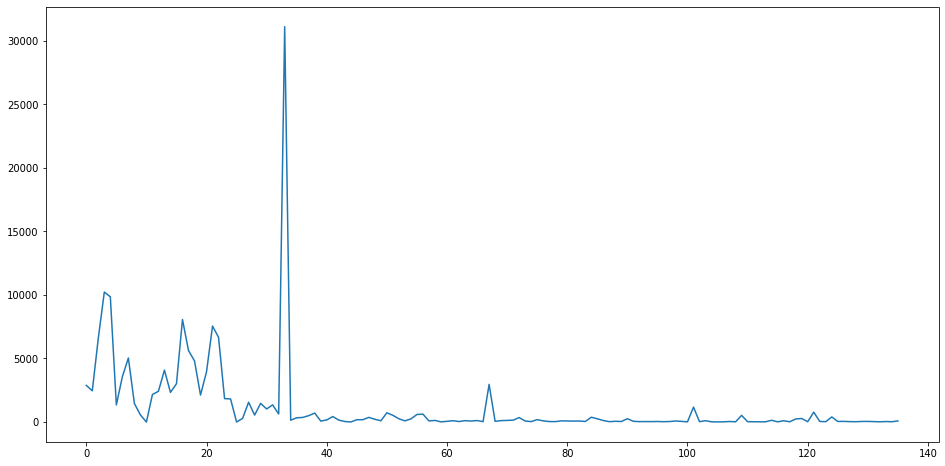

In [142]:
ppl.fit(1,freq=10)

In [152]:
ppl.train[0][0][0]

array([[[0.        , 0.        , 0.        , ..., 0.08380603,
         1.        , 0.        ],
        [0.00545256, 1.        , 1.        , ..., 0.08380603,
         0.99999998, 0.        ],
        [0.01090513, 1.        , 1.        , ..., 0.08380603,
         0.99999997, 0.10390058],
        ...,
        [0.2868048 , 0.        , 1.        , ..., 0.08380603,
         0.99999912, 0.09018888],
        [0.29334787, 0.        , 1.        , ..., 0.08380603,
         0.9999991 , 0.08991766],
        [0.29989095, 0.        , 1.        , ..., 0.08380603,
         0.99999908, 0.08964727]],

       [[0.00545256, 1.        , 1.        , ..., 0.08380603,
         0.99999998, 0.        ],
        [0.01090513, 1.        , 1.        , ..., 0.08380603,
         0.99999997, 0.10390058],
        [0.01635769, 0.        , 1.        , ..., 0.08380603,
         0.99999995, 0.10358823],
        ...,
        [0.29334787, 0.        , 1.        , ..., 0.08380603,
         0.9999991 , 0.08991766],
        [0.2

In [150]:
t.values

array([[35236, 96212, 1380, ..., 0, 0, 1],
       [35241, 96212, 1380, ..., 0, 0, 1],
       [35247, 96212, 1380, ..., 0, 0, 1],
       ...,
       [35529, 96212, 1380, ..., 0, 0, 1],
       [35535, 96212, 1380, ..., 0, 0, 1],
       [35541, 96212, 1380, ..., 0, 0, 1]], dtype=object)

In [144]:
ppl.model.predict(t.values)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [169]:
ppl.feature_amount()

49

## есть относительно удачные

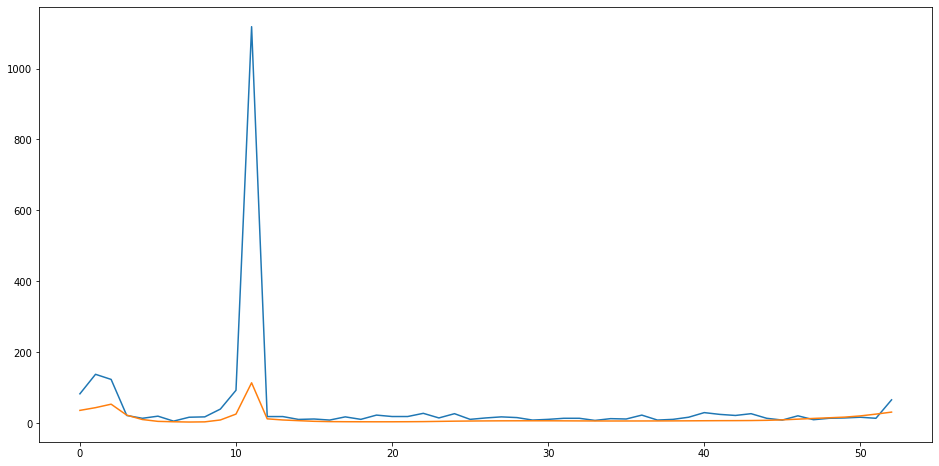

wape : [47.04006906579524]


In [245]:
ppl.sample(33,'wape')

## и не очень

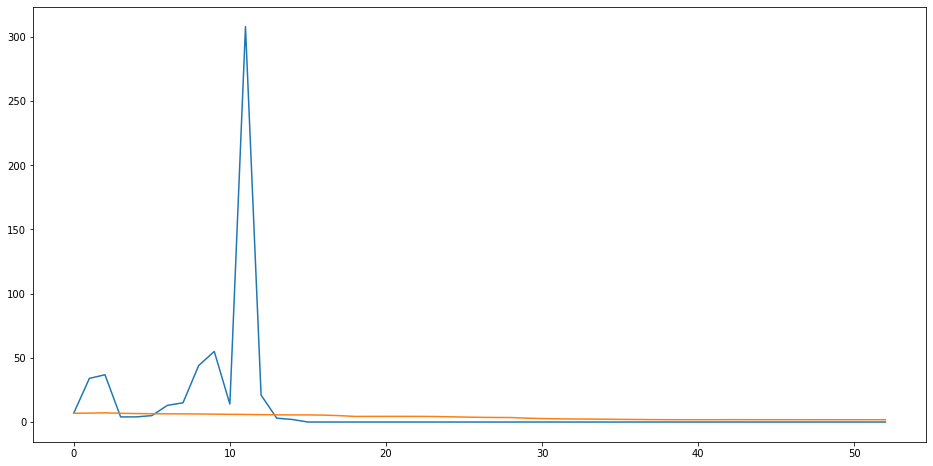

wape : [62.260499572339455]


In [242]:
ppl.sample(8,'wape')

In [50]:
ppl.feature_amount()

17